# Check real latency

In [1]:
from utils.load_results import load_data
import numpy as np
import pylab as plt
import scipy.signal as sg
from scipy.stats import zscore
import h5py

/Users/belinskaia/.pyenv/versions/3.9.1/envs/brain3/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Selecting the target signal
The task of selecting the target signal is divided into in two phases of processing: spatial and temporal filtering. 

### Spatial filtering
At the stage of spatial filtering, multi-channel signals are combined into one virtual channel, which has a well-defined physiological interpretation. We need to extract information about this virtual channel of the sharpening alpha rhythm from our test subject, created during the experiment.

### Temporal filtering
During the temporal filtering stage, the virtual signal goes through the frequency analysis, in which the oscillatory components of physiological activity are being determined. Some additional information can be found while selecting the envelope of a narrow-band signal. 

###  Envelope extraction
Real-time envelope extraction requires the use of specific signal analysis techniques, which also produce a delay, since we cannot accurately predict how the signal will change in the future. To find out how long this whole process takes, we can take an offline record and calculate the instantaneous alpha amplitude on it, extracted from an EEG with zero delay in an offline analysis. After correlating these two signals, this way we will know the accuracy of our neurofeedback and its delay.

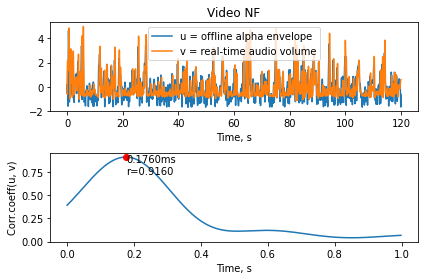

In [4]:
file_path = r'/Users/belinskaia/Desktop/video_fb_subj_test1_08-04_12-18-44/experiment_data.h5'

is_audio = 0

with h5py.File(file_path) as f:
    if is_audio:
        spat_filter = f['protocol6/signals_stats/Signal/spatial_filter'][...]
        band = f['protocol6/signals_stats/Signal/bandpass'][...]
    else:
        spat_filter = f['protocol6/signals_stats/Alpha0/spatial_filter'][...]
        band = f['protocol6/signals_stats/Alpha0/bandpass'][...]

df, fs, channels, p_names = load_data(file_path)
slc = np.arange(2*60*fs, 4*60*fs)
fb = df.query('block_name == "FB"' if is_audio else 'block_name == "FB0"')[channels].values[slc].dot(spat_filter)
fb = sg.filtfilt(*sg.butter(4, band/fs*2, 'band'), fb)
fb = np.abs(sg.hilbert(zscore(fb)))
# fb = (np.tanh(fb)/2+0.5)**4
fb = zscore(fb)

sens = df.query('block_name == "FB"' if is_audio else 'block_name == "FB0"')['AUDIO' if is_audio else 'VIDEO'].values[slc]
sens = sg.filtfilt(*sg.butter(4, [3/fs*2], 'low'), sens)
# sens = (sens+0.001)**(1/4)
sens = zscore(sens)


fig, axes = plt.subplots(2)
axes[0].set_title('Audio NF' if is_audio else 'Video NF')
axes[0].plot(np.arange(len(fb))/fs, fb)
axes[0].plot(np.arange(len(sens))/fs, sens)
axes[0].set_xlabel('Time, s')
axes[0].legend(['u = offline alpha envelope', 'v = real-time audio volume'])

corrs = [np.corrcoef(np.roll(fb, d), sens)[1, 0] for d in range(fs)]
axes[1].plot(np.arange(fs)/fs, corrs)
axes[1].plot(np.argmax(corrs)/fs, np.max(corrs), 'ro')
axes[1].text(np.argmax(corrs)/fs, np.max(corrs)*0.8, f'{np.argmax(corrs)/fs:.4f}ms\nr={np.max(corrs):.4f}')
axes[1].set_xlabel('Time, s')
axes[1].set_ylabel('Corr.coeff(u, v)')

plt.tight_layout()
plt.show()

### The real delay in our experiment is 176 ms, and the accuracy (correlation coefficient) is 0.91.